<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/trend_surface_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trend Surface Analysis

Zia Ahmed, University at Buffalo

Trend Surface Analysis (TSA) is a deterministic method used for spatial interpolation and modeling. It is particularly useful when you want to capture and describe the broad, systematic trends or patterns in a set of data points distributed across a geographic area. TSA fits a polynomial equation to the data points, allowing you to create a smooth surface that represents the general trend in the data.

Here are the key aspects of Trend Surface Analysis:

1. **Data Points**: TSA begins with a set of data points that represent measurements or observations across a geographic region. These data points can relate to various types of information, such as elevation, temperature, or any other variable that exhibits spatial variation.

2. **Polynomial Equation**: The core of TSA is fitting a polynomial equation to the data points. The polynomial equation represents a mathematical surface that approximates the trend or pattern observed in the data.

3. **Polynomial Degree**: The degree of the polynomial equation is a critical aspect of TSA. The choice of degree determines the complexity of the model and its ability to capture different types of trends.

 - **Cubic (Third-Degree) Polynomial**: A cubic equation adds terms for cubic trends, which can capture even more intricate spatial patterns.

4. **Coefficient Estimation**: To perform TSA, you need to estimate the coefficients (a, b, c, etc.) of the polynomial equation that best fits the data points. This is often done through a process of regression or least-squares estimation, where the goal is to minimize the error between the predicted values from the polynomial equation and the actual data points.

5. **Interpolation and Visualization**: Once you have determined the coefficients of the polynomial equation, you can use this equation to predict values at unmeasured locations within the geographic area. The result is a smooth, continuous surface that represents the general trend or pattern in the data. This surface can be visualized as a contour map, 3D surface, or other forms of spatial representation.

6. **Advantages and Limitations**:
   - Advantages of TSA include its simplicity, ability to capture and visualize general trends, and ease of interpretation.
   - Limitations include the potential inability to capture complex localized variations, as it focuses on broad trends, and it may not provide measures of uncertainty or error associated with predictions.

Trend Surface Analysis is commonly used in geology, geography, and various environmental sciences to model and understand large-scale spatial trends, such as elevation changes, temperature gradients, or population distribution. It's a valuable tool when you want to create a simple, smooth representation of data to identify overarching spatial patterns.

### Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314933 sha256=53fe5558a2f999e5ec6f7f3d6e73f7b4e8f24e54a02d951f59767284457e7787
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot', 'ggmap','plyr')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Install 'spatstat','dismo', and 'fields'


In [ ]:
%%R
install.packages(c('spatstat','dismo','fields'), lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (tidyverse)
library (terra)
library (tidyterra)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(plyr)
library(spatstat)
library(dismo)
library(fields)

### Data

The following data will be used in the exercise that can be found [here](https://github.com/zia207/r-colab/tree/main/Data/Spatial_interpolation).

1. train_data.csv

2. GP_STATE.shp

3. GP_prediction_grid_data.csv

In [ ]:
%%R
train<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/train_data.csv')
grid<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_prediction_grid_data.csv')
state<-shapefile("/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_STATE.shp")

Rows: 368 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10674 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): x, y, Aspect, ELEV, FRG, K_Factor, MAP, MAT, NDVI, NLCD, Slit_Clay...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R
glimpse(train)

Rows: 368
Columns: 21
$ ID        <dbl> 87, 52, 75, 55, 51, 77, 265, 82, 67, 188, 250, 224, 229, 164…
$ STATE_ID  <dbl> 35, 8, 35, 35, 8, 35, 35, 35, 35, 8, 35, 35, 8, 8, 35, 8, 8,…
$ STATE     <chr> "New Mexico", "Colorado", "New Mexico", "New Mexico", "Color…
$ FIPS      <dbl> 35003, 8033, 35003, 35031, 8033, 35006, 35015, 35003, 35003,…
$ COUNTY    <chr> "Catron County", "Dolores County", "Catron County", "McKinle…
$ x         <dbl> -1116586.5, -1107341.6, -1128512.3, -1137299.0, -1106344.8, …
$ y         <dbl> 1228025, 1699359, 1281006, 1446994, 1716869, 1419122, 105112…
$ SOC       <dbl> 1.333, 3.782, 3.393, 4.594, 5.995, 7.596, 10.276, 3.842, 11.…
$ ELEV      <dbl> 2192.513, 2328.449, 2357.302, 2261.782, 2404.112, 2514.776, …
$ Aspect    <dbl> 174.4923, 219.6880, 173.9527, 222.3785, 183.5729, 165.2028, …
$ Slope     <dbl> 8.080985, 10.462741, 8.016197, 4.874323, 6.680480, 6.598982,…
$ TPI       <dbl> -0.42157000, 0.55147684, -3.36669755, -1.44094825, 7.7656183…
$ K_Factor  <dbl> 

### Create prediction grid

In [ ]:
%%R
p.grid<-grid[,1:2]
head(p.grid)

# A tibble: 6 × 2
         x       y
     <dbl>   <dbl>
1 -1185285 2533795
2 -1175285 2533795
3 -1165285 2533795
4 -1155285 2533795
5 -1145285 2533795
6 -1135285 2533795


In [ ]:
%%R
coordinates(train) = ~x+y
coordinates(p.grid) = ~x+y
gridded(p.grid) <- TRUE

### Linear (First-Degree) Polynomial

A linear equation, represented as Z(x, y) = a + bx + cy, captures a simple trend that may involve a constant (a), a linear trend in the x direction (b), and a linear trend in the y direction (c).

We will use **krige()** function of **gstat** package without the geographic coordinates specified. It will perform ordinary or weighted least squares prediction:

In [ ]:
%%R
trend_1st<-krige(SOC ~ x + y, train, p.grid)

[ordinary or weighted least squares prediction]


In [ ]:
%%R
summary(trend_1st)

Object of class SpatialPixelsDataFrame
Coordinates:
       min     max
x -1250285  119715
y   998795 2538795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Grid attributes:
  cellcentre.offset cellsize cells.dim
x          -1245285    10000       137
y           1003795    10000       154
Data attributes:
   var1.pred        var1.var    
 Min.   :2.814   Min.   :24.13  
 1st Qu.:5.153   1st Qu.:24.17  
 Median :6.549   Median :24.24  
 Mean   :6.316   Mean   :24.26  
 3rd Qu.:7.383   3rd Qu.:24.34  
 Max.   :9.251   Max.   :24.62  


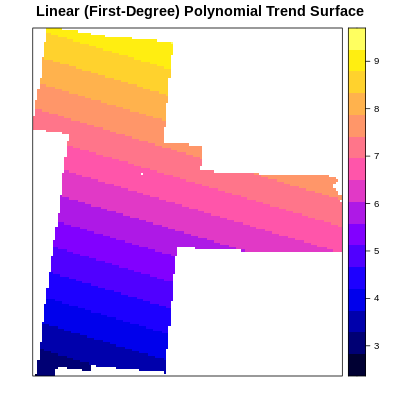

In [ ]:
%%R -w 400 -h 400 -u px
spplot(trend_1st ,"var1.pred",
       main= "Linear (First-Degree) Polynomial Trend Surface")

### Quadratic (Second-Degree) Polynomial

 A quadratic equation, such as Z(x, y) = a + bx + cy + dx^2 + exy + fy^2, can model more complex trends, including curvatures.

In [ ]:
%%R
trend_2nd<-krige(SOC ~ x + y + I(x*y) + I(x^2) + I(y^2), train, p.grid)
summary(trend_2nd)

[ordinary or weighted least squares prediction]
Object of class SpatialPixelsDataFrame
Coordinates:
       min     max
x -1250285  119715
y   998795 2538795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Grid attributes:
  cellcentre.offset cellsize cells.dim
x          -1245285    10000       137
y           1003795    10000       154
Data attributes:
   var1.pred          var1.var    
 Min.   : 0.5955   Min.   :22.04  
 1st Qu.: 5.1468   1st Qu.:22.09  
 Median : 6.1480   Median :22.17  
 Mean   : 6.2871   Mean   :22.28  
 3rd Qu.: 7.7320   3rd Qu.:22.39  
 Max.   :12.1479   Max.   :23.67  


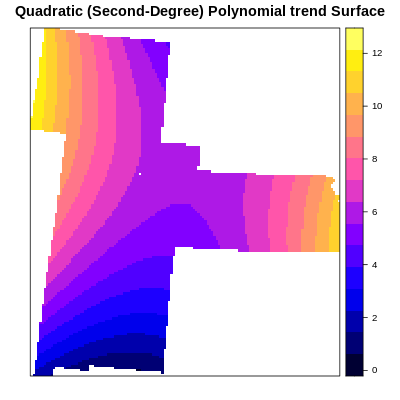

In [ ]:
%%R -w 400 -h 400 -u px
spplot(trend_2nd ,"var1.pred",
       main= "Quadratic (Second-Degree) Polynomial trend Surface")

### Cubic (Third-Degree) Polynomial:
A cubic equation adds terms for cubic trends, which can capture even more intricate spatial patterns.

In [ ]:
%%R
trend_3rd<-krige(SOC ~ x+y + x*y+I(x^2)+I(y^2) + I(x^3)+I(x^2*y)+I(x*y^2)+I(y^3), train, p.grid)
summary(trend_3rd)

[ordinary or weighted least squares prediction]
Object of class SpatialPixelsDataFrame
Coordinates:
       min     max
x -1250285  119715
y   998795 2538795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Grid attributes:
  cellcentre.offset cellsize cells.dim
x          -1245285    10000       137
y           1003795    10000       154
Data attributes:
   var1.pred         var1.var    
 Min.   :-1.178   Min.   :21.93  
 1st Qu.: 5.289   1st Qu.:22.01  
 Median : 6.150   Median :22.12  
 Mean   : 6.345   Mean   :22.33  
 3rd Qu.: 7.617   3rd Qu.:22.43  
 Max.   :13.402   Max.   :26.12  


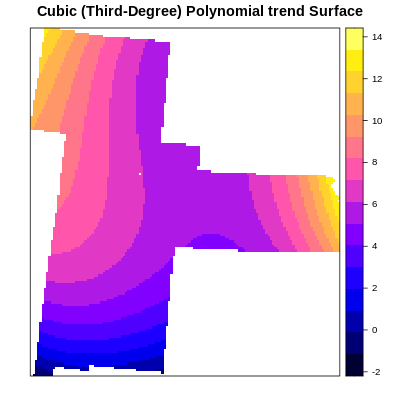

In [ ]:
%%R -w 400 -h 400 -u px
spplot(trend_3rd ,"var1.pred",
       main= "Cubic (Third-Degree) Polynomial trend Surface")

### Further Reading

1. [Deterministic methods for spatial interpolation](https://pro.arcgis.com/en/pro-app/latest/help/analysis/geostatistical-analyst/deterministic-methods-for-spatial-interpolation.htm)

2. [Spatial Interpolation Methods](https://iri.columbia.edu/~rijaf/CDTUserGuide/html/interpolation_methods.html)

3. [Chapter 14 Spatial Interpolation](https://mgimond.github.io/Spatial/spatial-interpolation.html#spatial-interpolation)